In [12]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import timedelta, date
import sqlite3
fake = Faker()
Faker.seed(42)
np.random.seed(42)
random.seed(42)

NUM_TRENDS      = 160
ROWS_PER_TREND  = (10, 15)    # inclusive
TREND_DURATION  = 30          # days
RESALE_MAX_LAG  = 15          # days after trend end

CATEGORIES      = ['clothing','accessories','electronics','home','beauty']
AGE_GROUPS      = ['18-25','26-35','36-45','46-55','55+']

POS_TEMPLATES = {
    'clothing':    ["I absolutely love this {cat}, it fits perfectly!",
                    "The {cat} exceeded my expectations, will buy again."],
    'accessories': ["The {cat} is stylish and durable, totally worth it.",
                    "Fantastic {cat}! I've gotten so many compliments."],
    'electronics': ["This {cat} works like a charm, very satisfied.",
                    "High quality {cat}, packing and delivery were quick!"],
    'home':        ["The {cat} looks great in my living room!", 
                    "Very happy with this {cat}, great craftsmanship."],
    'beauty':      ["My skin loves this {cat}, highly recommend!", 
                    "Excellent {cat}, noticeable results already."]
}
NEG_TEMPLATES = {
    'clothing':    ["The {cat} was poorly stitched, very disappointed.",
                    "This {cat} shrank after one wash—would not recommend."],
    'accessories': ["The {cat} feels cheap and flimsy.", 
                    "I expected better quality from this {cat}."],
    'electronics': ["The {cat} died after a week, what a waste.",
                    "Terrible {cat}, arrived DOA and wouldn't power on."],
    'home':        ["The {cat} arrived damaged, customer service was useless.",
                    "Poor quality {cat}, looks nothing like the photos."],
    'beauty':      ["This {cat} broke me out, really unhappy with it.",
                    "The {cat} formula is irritating, skin feels dry and itchy."]
}

trend_records = []
trend_windows = {}

for i in range(1, NUM_TRENDS + 1):
    tid         = f"T{str(i).zfill(3)}"
    raw_start   = fake.date_between(start_date='-1y', end_date='today')
    raw_end     = raw_start + timedelta(days=TREND_DURATION)
    real_end    = min(raw_end, date.today())
    category    = random.choice(CATEGORIES)

    trend_windows[tid] = {
        "start": raw_start,
        "end": real_end,
        "category": category
    }

    count = random.randint(*ROWS_PER_TREND)
    for _ in range(count):
        run_date = fake.date_between(start_date=raw_start, end_date=real_end)
        views    = random.randint(1000, 10000)
        trend_records.append({
            "serial_number":    len(trend_records) + 1,
            "trend_id":         tid,
            "current_date":     run_date,
            "product_category": category,
            "views":            views,
            "likes":            random.randint(0, views),
            "comments":         random.randint(0, max(1, views // 10)),
            "shares":           random.randint(0, max(1, views // 20))
        })

trends_df = pd.DataFrame(trend_records)


txn_records = []

for tid, info in trend_windows.items():
    start = info["start"]
    end   = info["end"]
    cat   = info["category"]

    # Generate random number of transactions for this trend
    num_txns = random.randint(*ROWS_PER_TREND)

    for _ in range(num_txns):
        tx_index = len(txn_records) + 1
        tx_id = f"TX{str(tx_index).zfill(5)}"
        prod_id = f"P{str(tx_index).zfill(5)}"  # unique per transaction

        tx_date = fake.date_between(start_date=start, end_date=end)
        price = round(random.uniform(10, 200), 2)
        qty = random.randint(1, 5)
        age_grp = random.choice(AGE_GROUPS)

        template = (
            random.choice(POS_TEMPLATES[cat])
            if random.random() < 0.7
            else random.choice(NEG_TEMPLATES[cat])
        )

        txn_records.append({
            "trend_id":           tid,
            "product_id":         prod_id,
            "product_category":   cat,
            "transaction_id":     tx_id,
            "transaction_date":   tx_date,
            "original_price":     price,
            "quantity":           qty,
            "customer_age_group": age_grp,
            "customer_review":    template.format(cat=cat)
        })

transactions_df = pd.DataFrame(txn_records)


sampled = transactions_df.sample(n=1200, random_state=42).reset_index(drop=True)
resale_records = []

for i, tx in sampled.iterrows():
    resale_id = f"RS{str(i+1).zfill(5)}"
    start = tx["transaction_date"] + timedelta(days=1)
    end   = min(date.today(), trend_windows[tx["trend_id"]]["end"] + timedelta(days=RESALE_MAX_LAG))

    if start > end:
        start = end

    resale_date = fake.date_between(start_date=start, end_date=end)
    resale_price = round(tx["original_price"] * random.uniform(0.5, 1.2), 2)

    resale_records.append({
        "product_id":       tx["product_id"],
        "resale_id":        resale_id,
        "resale_list_date": resale_date,
        "resale_price":     resale_price
    })

resale_df = pd.DataFrame(resale_records)


with pd.ExcelWriter("trends_transactions_resale.xlsx", engine="openpyxl") as writer:
    trends_df.to_excel(writer,      sheet_name="Trends_data", index=False)
    transactions_df.to_excel(writer, sheet_name="Transactions", index=False)
    resale_df.to_excel(writer,       sheet_name="Resale", index=False)

print("Wrote trends_transactions_resale.xlsx with 3 fully separated sheets.")


conn = sqlite3.connect("IProject.db")
trends_df.to_sql("Trends_data", conn, if_exists="replace", index=False)
transactions_df.to_sql("Transactions", conn, if_exists="replace", index=False)
resale_df.to_sql("Resale", conn, if_exists="replace", index=False)
conn.close()

print("Saved all tables to IProject.db.")


Wrote trends_transactions_resale.xlsx with 3 fully separated sheets.
Saved all tables to IProject.db.


In [14]:
import pandas as pd

xls = pd.ExcelFile("trends_transactions_resale.xlsx")
trends      = pd.read_excel(xls, sheet_name="Trends_data")
transactions = pd.read_excel(xls, sheet_name="Transactions")
resale      = pd.read_excel(xls, sheet_name="Resale")

trends_clean = trends[trends["likes"] > 0].copy()
trends_clean = trends_clean[(trends_clean["views"] / trends_clean["likes"]) < 100]

transactions_clean = (
    transactions
    .drop_duplicates(subset="transaction_id")
    .loc[lambda df: df["original_price"] > 0]
)

resale_clean = resale.drop_duplicates(subset="resale_id").copy()
resale_clean = resale_clean[resale_clean["resale_price"] > 0]

resale_clean = (
    resale_clean
    .merge(
        transactions_clean[["product_id", "transaction_date"]],
        on="product_id",
        how="left"
    )
    .query("resale_list_date > transaction_date")
    .loc[:, ["product_id", "resale_id", "resale_list_date", "resale_price"]]
)

with pd.ExcelWriter("cleaned_data1.xlsx", engine="openpyxl") as writer:
    trends_clean.to_excel(writer, sheet_name="Trends_data", index=False)
    transactions_clean.to_excel(writer, sheet_name="Transactions", index=False)
    resale_clean.to_excel(writer, sheet_name="Resale", index=False)

print(f"Trends_data: {len(trends)} → {len(trends_clean)} rows")
print(f"Transactions: {len(transactions)} → {len(transactions_clean)} rows")
print(f"Resale: {len(resale)} → {len(resale_clean)} rows")


Trends_data: 1995 → 1982 rows
Transactions: 2003 → 2003 rows
Resale: 1200 → 1200 rows


In [6]:
import pandas as pd
import sqlite3

xls = pd.ExcelFile("cleaned_data1.xlsx")
trends_clean      = pd.read_excel(xls, sheet_name="Trends_data")
transactions_clean = pd.read_excel(xls, sheet_name="Transactions")
resale_clean      = pd.read_excel(xls, sheet_name="Resale")

conn = sqlite3.connect("IProject.db")
trends_clean.to_sql("Trends_data", conn, if_exists="replace", index=False)
transactions_clean.to_sql("Transactions", conn, if_exists="replace", index=False)
resale_clean.to_sql("Resale", conn, if_exists="replace", index=False)

c = conn.cursor()
c.execute("ALTER TABLE Trends_data ADD COLUMN current_engagement_rate REAL;")
c.execute("""
    UPDATE Trends_data
    SET current_engagement_rate = ((likes + comments + shares) * 1.0 / views) * 100;
""")

conn.commit()
conn.close()


In [16]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("IProject.db")

df_top5 = pd.read_sql_query(
    "SELECT * FROM Trends_data LIMIT 5;",
    conn
)

print(df_top5)

conn.close()


   serial_number trend_id current_date product_category  views  likes  \
0              1     T001   2025-04-16         clothing   5506   2006   
1              2     T001   2025-04-12         clothing   2679   2233   
2              3     T001   2025-04-24         clothing   1520     61   
3              4     T001   2025-04-22         clothing   4811   4139   
4              5     T001   2025-04-21         clothing   4257   3436   

   comments  shares  
0       228      71  
1        44     108  
2        23      27  
3       308       6  
4       112     114  


In [18]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("IProject.db")
c = conn.cursor()

c.execute("DROP TABLE IF EXISTS Final_Product_Data;")

c.execute("""
CREATE TABLE Final_Product_Data AS
SELECT
  t.trend_id,
  t.product_category,

  -- first transaction date for each trend
  (SELECT MIN(tx.transaction_date)
     FROM Transactions AS tx
    WHERE tx.trend_id = t.trend_id
  ) AS trend_start_date,

  -- last transaction date for each trend
  (SELECT MAX(tx.transaction_date)
     FROM Transactions AS tx
    WHERE tx.trend_id = t.trend_id
  ) AS trend_end_date,

  -- the date with the highest engagement rate
  (SELECT td.current_date
     FROM Trends_data AS td
    WHERE td.trend_id = t.trend_id
    ORDER BY 
      (td.likes + td.comments + td.shares) * 100 / td.views DESC
    LIMIT 1
  ) AS trend_peak_date,

  -- the maximum engagement rate itself
  (SELECT MAX(
      (td2.likes + td2.comments + td2.shares) * 100 / td2.views
    )
     FROM Trends_data AS td2
    WHERE td2.trend_id = t.trend_id
  ) AS peak_engagement

FROM (
  SELECT DISTINCT trend_id, product_category
    FROM Trends_data
) AS t;
""")

conn.commit()

df = pd.read_sql_query("SELECT * FROM Final_Product_Data LIMIT 5;", conn)
print(df)

conn.close()

  trend_id product_category trend_start_date trend_end_date trend_peak_date  \
0     T001         clothing       2025-04-12     2025-05-10      2025-05-09   
1     T002         clothing       2025-01-22     2025-02-14      2025-01-17   
2     T003             home       2025-01-27     2025-02-23      2025-02-03   
3     T004      electronics       2024-09-12     2024-10-09      2024-10-07   
4     T005      electronics       2025-03-18     2025-04-14      2025-04-05   

   peak_engagement  
0               98  
1              106  
2              108  
3              105  
4               78  


In [20]:
conn = sqlite3.connect("IProject.db")
c = conn.cursor()

c.execute("ALTER TABLE Resale ADD COLUMN reason TEXT;")

c.execute("""
UPDATE Resale
SET reason = 'Regret'
WHERE resale_list_date >= (
      SELECT date(F.trend_peak_date, '+7 days')
        FROM Final_Product_Data F
        JOIN Transactions T ON F.trend_id = T.trend_id
       WHERE T.product_id = Resale.product_id
)
  AND resale_list_date <= (
      SELECT F.trend_end_date
        FROM Final_Product_Data F
        JOIN Transactions T ON F.trend_id = T.trend_id
       WHERE T.product_id = Resale.product_id
);
""")

conn.commit()

df_top10 = pd.read_sql_query("SELECT * FROM Resale LIMIT 10;", conn)
print(df_top10)

  product_id resale_id resale_list_date  resale_price  reason
0     P01395   RS00001       2024-11-02         73.85    None
1     P00354   RS00002       2025-01-08        107.62  Regret
2     P01335   RS00003       2025-01-05          9.75    None
3     P00907   RS00004       2025-03-15        135.49  Regret
4     P01291   RS00005       2025-06-25         20.94    None
5     P01275   RS00006       2025-03-14        128.12    None
6     P00940   RS00007       2025-08-07         64.67    None
7     P01734   RS00008       2025-07-22         22.09    None
8     P00066   RS00009       2025-03-30         92.74    None
9     P01048   RS00010       2025-05-10        128.66    None


In [22]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("IProject.db")
c = conn.cursor()

c.execute("DROP TABLE IF EXISTS merged_data;")
c.execute("""
CREATE TABLE merged_data AS
SELECT
  T.transaction_id,
  R.resale_id,
  T.product_id,
  T.product_category,
  T.transaction_date,
  R.resale_list_date,
  T.original_price,
  R.resale_price,
  T.customer_review AS customer_reviews,
  R.reason
FROM Transactions T
INNER JOIN Resale R
  ON T.product_id = R.product_id;
""")
conn.commit()

df_top10 = pd.read_sql_query("SELECT * FROM merged_data LIMIT 10;", conn)
print(df_top10)
conn.close()



  transaction_id resale_id product_id product_category transaction_date  \
0        TX00001   RS01179     P00001         clothing       2025-04-28   
1        TX00003   RS00453     P00003         clothing       2025-04-20   
2        TX00004   RS01012     P00004         clothing       2025-05-10   
3        TX00006   RS01017     P00006         clothing       2025-04-30   
4        TX00007   RS00670     P00007         clothing       2025-05-05   
5        TX00008   RS01081     P00008         clothing       2025-04-12   
6        TX00011   RS00827     P00011         clothing       2025-04-17   
7        TX00013   RS00960     P00013         clothing       2025-02-07   
8        TX00016   RS00533     P00016         clothing       2025-01-23   
9        TX00019   RS00718     P00019         clothing       2025-01-22   

  resale_list_date  original_price  resale_price  \
0       2025-05-11          105.88        121.44   
1       2025-05-24          137.60         82.12   
2       2025-05-19

In [12]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("IProject.db")
c = conn.cursor()

c.execute("PRAGMA journal_mode = WAL;")
c.execute("PRAGMA temp_store = MEMORY;")
c.execute("PRAGMA synchronous = NORMAL;")

c.executescript("""
CREATE INDEX IF NOT EXISTS idx_trends_trendid           ON Trends_data(trend_id);
CREATE INDEX IF NOT EXISTS idx_trends_trendid_currdate  ON Trends_data(trend_id, "current_date");

CREATE INDEX IF NOT EXISTS idx_txn_trendid              ON Transactions(trend_id);
CREATE INDEX IF NOT EXISTS idx_txn_txid                 ON Transactions(transaction_id);
CREATE INDEX IF NOT EXISTS idx_txn_prodid               ON Transactions(product_id);

CREATE INDEX IF NOT EXISTS idx_fpd_trendid              ON Final_Product_Data(trend_id);

CREATE INDEX IF NOT EXISTS idx_resale_prodid            ON Resale(product_id);

CREATE INDEX IF NOT EXISTS idx_merged_txid              ON merged_data(transaction_id);
CREATE INDEX IF NOT EXISTS idx_merged_prodid            ON merged_data(product_id);
""")

try:
    c.execute("ALTER TABLE merged_data ADD COLUMN trend_id TEXT;")
    conn.commit()
except sqlite3.OperationalError:
    pass  

c.execute("""
UPDATE merged_data
SET trend_id = (
    SELECT T.trend_id
    FROM Transactions T
    WHERE T.transaction_id = merged_data.transaction_id
)
WHERE trend_id IS NULL;
""")
conn.commit()

c.execute("CREATE INDEX IF NOT EXISTS idx_merged_trendid ON merged_data(trend_id);")

try:
    c.execute("ALTER TABLE merged_data ADD COLUMN price_drop_percent REAL;")
    conn.commit()
except sqlite3.OperationalError:
    pass  

c.execute("""
UPDATE merged_data
SET price_drop_percent = 
    ((original_price - resale_price) / NULLIF(original_price, 0)) * 100.0;
""")
conn.commit()

try:
    c.execute("ALTER TABLE merged_data ADD COLUMN days_since_trend_peak INTEGER;")
    conn.commit()
except sqlite3.OperationalError:
    pass

c.execute("""
UPDATE merged_data
SET days_since_trend_peak = CAST(
    (julianday(transaction_date) - julianday(
        (SELECT F.trend_peak_date 
         FROM Final_Product_Data F
         WHERE F.trend_id = merged_data.trend_id)
    )) AS INTEGER
);
""")
conn.commit()

try:
    c.execute("ALTER TABLE Trends_data ADD COLUMN engagement_decay_rate REAL;")
    conn.commit()
except sqlite3.OperationalError:
    pass  

c.execute("""
UPDATE Trends_data AS TD
SET engagement_decay_rate = 
(
    (
        (SELECT F.peak_engagement
         FROM Final_Product_Data F
         WHERE F.trend_id = TD.trend_id)
        -
        (
            ( (COALESCE(TD.likes,0) + COALESCE(TD.comments,0) + COALESCE(TD.shares,0)) * 100.0 )
            / NULLIF(TD.views, 0)
        )
    )
    /
    NULLIF(
        (julianday(TD.current_date) - julianday(
            (SELECT F.trend_peak_date
             FROM Final_Product_Data F
             WHERE F.trend_id = TD.trend_id)
        )),
        0
    )
);
""")
conn.commit()

print("\n=== merged_data (sample) ===")
df_m = pd.read_sql_query("""
SELECT 
  transaction_id, product_id, trend_id,
  original_price, resale_price, price_drop_percent,
  transaction_date,
  (SELECT trend_peak_date FROM Final_Product_Data F WHERE F.trend_id = merged_data.trend_id) AS trend_peak_date,
  days_since_trend_peak,
  reason
FROM merged_data
LIMIT 10;
""", conn)
print(df_m)

print("\n=== Trends_data (sample) ===")
df_t = pd.read_sql_query("""
SELECT 
  TD.trend_id, TD.current_date, TD.views, TD.likes, TD.comments, TD.shares,
  ((TD.likes + TD.comments + TD.shares) * 100.0 / NULLIF(TD.views, 0)) AS current_engagement_rate_calc,
  (SELECT F.peak_engagement FROM Final_Product_Data F WHERE F.trend_id = TD.trend_id) AS peak_engagement,
  (SELECT F.trend_peak_date FROM Final_Product_Data F WHERE F.trend_id = TD.trend_id) AS trend_peak_date,
  TD.engagement_decay_rate
FROM Trends_data TD
LIMIT 10;
""", conn)
print(df_t)

conn.close()


=== merged_data (sample) ===
  transaction_id product_id trend_id  original_price  resale_price  \
0        TX00001     P00001     T001          105.88        121.44   
1        TX00003     P00003     T001          137.60         82.12   
2        TX00004     P00004     T001          119.60         75.07   
3        TX00006     P00006     T001           38.07         34.71   
4        TX00007     P00007     T001           70.54         75.14   
5        TX00008     P00008     T001          166.51         98.72   
6        TX00011     P00011     T001           90.18         73.34   
7        TX00013     P00013     T002          102.31        117.34   
8        TX00016     P00016     T002           54.85         39.42   
9        TX00019     P00019     T002          187.75        206.51   

   price_drop_percent transaction_date trend_peak_date  days_since_trend_peak  \
0          -14.695882       2025-04-28      2025-05-09                    -11   
1           40.319767       2025-04-2

In [17]:
db = "IProject.db"
conn = sqlite3.connect(db)
c = conn.cursor()

c.execute("PRAGMA journal_mode = WAL;")
c.execute("PRAGMA temp_store = MEMORY;")
c.execute("PRAGMA synchronous = NORMAL;")

sql_pct_within_14 = """
SELECT
  100.0 * SUM(
      CASE 
        WHEN (julianday(M.resale_list_date) - julianday(F.trend_peak_date)) BETWEEN 0 AND 14 
        THEN 1 ELSE 0 
      END
  ) / NULLIF(COUNT(*), 0) AS pct_returns_within_14d
FROM merged_data M
JOIN Final_Product_Data F
  ON F.trend_id = M.trend_id;
"""

df_pct14 = pd.read_sql_query(sql_pct_within_14, conn)
print("=== 1) % of resales within 14 days of peak ===")
print(df_pct14, "\n")

sql_avg_time_by_cat = """
SELECT
  product_category,
  AVG(julianday(resale_list_date) - julianday(transaction_date)) AS avg_days_to_resale,
  COUNT(*) AS n_resales
FROM merged_data
GROUP BY product_category
ORDER BY avg_days_to_resale;
"""
df_avg_time = pd.read_sql_query(sql_avg_time_by_cat, conn)
print("=== 2) Avg days to resale by product category ===")
print(df_avg_time, "\n")

sql_corr_dataset = """
WITH engagement_by_trend AS (
  SELECT 
    trend_id,
    AVG(views)    AS avg_views,
    AVG(likes)    AS avg_likes,
    AVG(comments) AS avg_comments,
    AVG(shares)   AS avg_shares
  FROM Trends_data
  GROUP BY trend_id
),
return_rate_by_trend AS (
  SELECT 
    T.trend_id,
    1.0 * (SELECT COUNT(*) FROM merged_data M WHERE M.trend_id = T.trend_id)
    / NULLIF(COUNT(*), 0) AS return_rate
  FROM Transactions T
  GROUP BY T.trend_id
)
SELECT 
  e.trend_id,
  e.avg_views, e.avg_likes, e.avg_comments, e.avg_shares,
  r.return_rate
FROM engagement_by_trend e
JOIN return_rate_by_trend r
  ON r.trend_id = e.trend_id;
"""
df_corr = pd.read_sql_query(sql_corr_dataset, conn)

print("=== 3) Trend-level engagement & return-rate dataset (sample) ===")
print(df_corr.head(10), "\n")

if not df_corr.empty:
    corr_with_return = df_corr[['avg_views','avg_likes','avg_comments','avg_shares']].corrwith(df_corr['return_rate'])
    print("=== Pearson correlation with return_rate ===")
    print(corr_with_return)

conn.close()


=== 1) % of resales within 14 days of peak ===
   pct_returns_within_14d
0               36.416667 

=== 2) Avg days to resale by product category ===
  product_category  avg_days_to_resale  n_resales
0      electronics           13.551020        294
1           beauty           13.857558        344
2         clothing           14.629630        243
3      accessories           15.042553        141
4             home           16.112360        178 

=== 3) Trend-level engagement & return-rate dataset (sample) ===
  trend_id    avg_views    avg_likes  avg_comments  avg_shares  return_rate
0     T001  4171.300000  1800.500000    142.400000   98.100000     0.583333
1     T002  4627.153846  2059.692308    225.692308  121.230769     0.400000
2     T003  5919.818182  2345.909091    327.363636  111.090909     0.500000
3     T004  5645.733333  2735.333333    213.400000  132.933333     0.785714
4     T005  7069.600000  2649.400000    354.100000  165.700000     0.666667
5     T006  6129.692308  2

In [21]:
import sqlite3
import pandas as pd

db = "IProject.db"
conn = sqlite3.connect(db)
c = conn.cursor()

try:
    c.execute("ALTER TABLE Transactions ADD COLUMN sentiment_score INTEGER;")
    conn.commit()
except sqlite3.OperationalError:
    pass

neg_phrases = [
    "poorly stitched", "shrank after one wash", "feels cheap",
    "expected better quality", "died after a week", "terrible",
    "arrived damaged", "poor quality", "broke me out", "irritating"
]

neg_like_clause = " OR ".join([f"LOWER(customer_review) LIKE '%{p.lower()}%'" for p in neg_phrases])

c.execute(f"""
UPDATE Transactions
SET sentiment_score = CASE
    WHEN {neg_like_clause} THEN -1
    ELSE 1
END
WHERE sentiment_score IS NULL;
""")
conn.commit()

c.execute("DROP VIEW IF EXISTS txn_with_return;")
c.execute("""
CREATE TEMP VIEW txn_with_return AS
SELECT 
    T.*,
    CASE WHEN R.product_id IS NOT NULL THEN 1 ELSE 0 END AS returned
FROM Transactions T
LEFT JOIN Resale R
  ON T.product_id = R.product_id;
""")

sql_neg_sentiment = """
SELECT
    AVG(CASE WHEN sentiment_score < 0 THEN 1.0 ELSE 0 END) AS negative_sentiment_rate,
    AVG(returned * 1.0) AS return_rate
FROM txn_with_return;
"""
df_neg_sent = pd.read_sql_query(sql_neg_sentiment, conn)
print("=== 2.1 Negative sentiment rate & return rate ===")
print(df_neg_sent, "\n")

df_low_ratio = pd.read_sql_query("""
SELECT
    product_id,
    AVG(resale_price / original_price) AS price_drop_ratio,
    COUNT(*) AS n_resales
FROM merged_data
GROUP BY product_id
HAVING AVG(resale_price / original_price) < 0.6
ORDER BY price_drop_ratio ASC
LIMIT 20;
""", conn)

print("Products with avg resale <=60% of original (sample):")
print(df_low_ratio)

df_worst_rows = pd.read_sql_query("""
SELECT product_id, original_price, resale_price,
       ROUND(resale_price / original_price, 3) AS ratio
FROM merged_data
ORDER BY ratio ASC
LIMIT 20;
""", conn)
print("\nWorst individual resale ratios (rows):")
print(df_worst_rows)

sql_age_return = """
SELECT
    customer_age_group,
    AVG(returned * 1.0) AS return_rate,
    COUNT(*) AS n_customers
FROM txn_with_return
GROUP BY customer_age_group
ORDER BY return_rate DESC;
"""
df_age_return = pd.read_sql_query(sql_age_return, conn)
print("=== 2.3 Age group vs return rates ===")
print(df_age_return, "\n")

conn.close()


=== 2.1 Negative sentiment rate & return rate ===
   negative_sentiment_rate  return_rate
0                 0.311533     0.599101 

Products with avg resale <=60% of original (sample):
   product_id  price_drop_ratio  n_resales
0      P01390          0.502120          1
1      P00772          0.503417          1
2      P01608          0.503555          1
3      P00927          0.503798          1
4      P01570          0.504067          1
5      P01771          0.506123          1
6      P01238          0.507816          1
7      P01728          0.508075          1
8      P01941          0.508080          1
9      P00669          0.508347          1
10     P01193          0.509118          1
11     P00436          0.509598          1
12     P01550          0.510037          1
13     P00239          0.510261          1
14     P00693          0.510282          1
15     P01334          0.510456          1
16     P00347          0.510500          1
17     P01982          0.510511          


=== 3.2 Regret rates by category (preview) ===
  product_category  regret_rate_among_returns  regret_rate_per_txn
0      accessories                      0.170                0.087
1           beauty                      0.169                0.110
2         clothing                      0.177                0.103
3      electronics                      0.177                0.107
4             home                      0.208                0.126


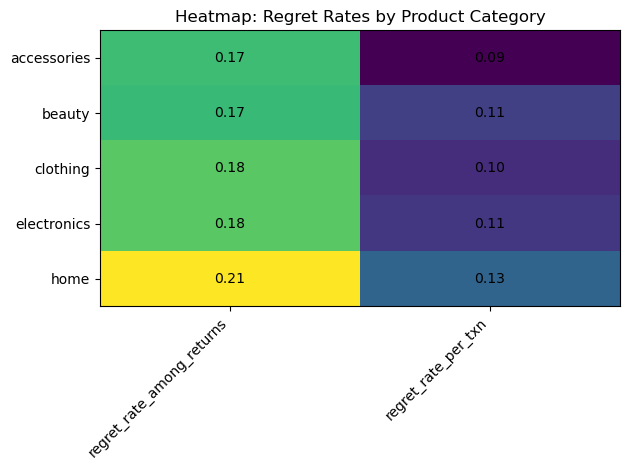


=== 3.3 Monthly sales & returns (preview) ===
      month  total_sales_qty  total_orders  total_returns
0   2024-08              199            65             43
1   2024-09              642           221            136
2   2024-10              443           165             88
3   2024-11              369           125             79
4   2024-12              472           159             94
5   2025-01              519           172            101
6   2025-02              553           177            105
7   2025-03              430           138             84
8   2025-04              531           176             98
9   2025-05              509           174             98
10  2025-06              465           151             93
11  2025-07              594           204            131


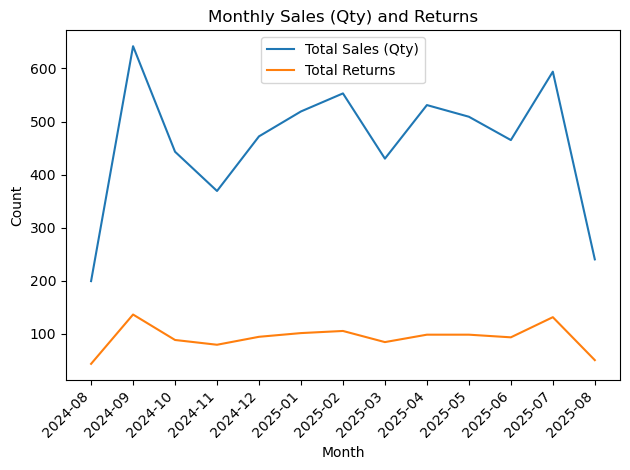


=== 3.4 Customer demographics & purchase behavior (preview) ===
  customer_age_group  purchases  total_qty  avg_purchase_value  return_rate
0              46-55        420       1268          314.627167     0.623810
1              26-35        413       1215          314.450944     0.629540
2              36-45        406       1189          307.577241     0.576355
3                55+        384       1129          306.151589     0.562500
4              18-25        380       1165          319.458974     0.600000


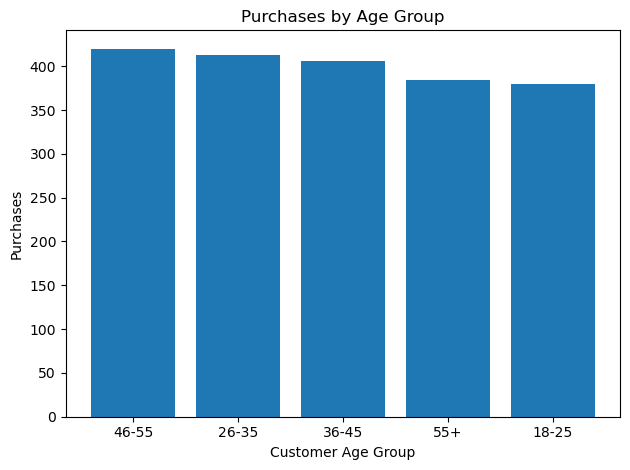

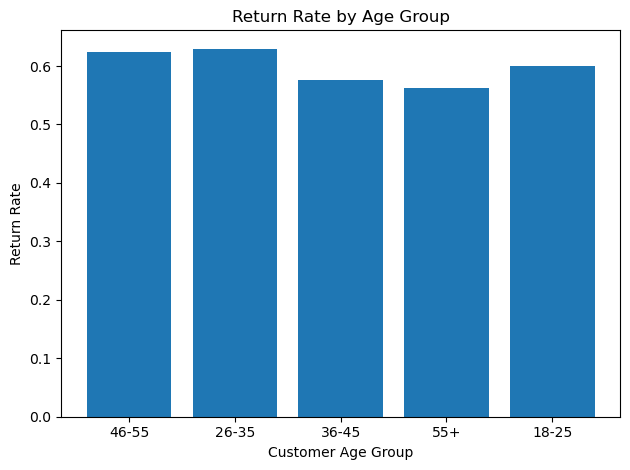

In [23]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

db = "IProject.db"
conn = sqlite3.connect(db)
cur = conn.cursor()

cur.execute("PRAGMA journal_mode = WAL;")
cur.execute("PRAGMA temp_store = MEMORY;")
cur.execute("PRAGMA synchronous = NORMAL;")

sql_regret_among_returns = """
SELECT
  product_category,
  AVG(CASE WHEN LOWER(COALESCE(reason,'')) = 'regret' THEN 1.0 ELSE 0 END) AS regret_rate_among_returns,
  COUNT(*) AS n_returns
FROM merged_data
GROUP BY product_category
ORDER BY product_category;
"""
df_regret_returns = pd.read_sql_query(sql_regret_among_returns, conn)

df_txn_by_cat = pd.read_sql_query("""
SELECT product_category, COUNT(*) AS n_txns
FROM Transactions
GROUP BY product_category;
""", conn)

df_regret_counts = pd.read_sql_query("""
SELECT product_category, 
       SUM(CASE WHEN LOWER(COALESCE(reason,'')) = 'regret' THEN 1 ELSE 0 END) AS regret_count
FROM merged_data
GROUP BY product_category;
""", conn)

df_regret_per_txn = df_txn_by_cat.merge(df_regret_counts, on="product_category", how="left").fillna({"regret_count":0})
df_regret_per_txn["regret_rate_per_txn"] = df_regret_per_txn["regret_count"] / df_regret_per_txn["n_txns"]

# Heatmap-ready matrix (categories x 2 metrics)
heat_df = df_regret_returns[["product_category","regret_rate_among_returns"]] \
    .merge(df_regret_per_txn[["product_category","regret_rate_per_txn"]], on="product_category", how="left") \
    .set_index("product_category").sort_index()

print("\n=== 3.2 Regret rates by category (preview) ===")
print(heat_df.reset_index().round(3).head(10))

fig1, ax1 = plt.subplots()
im = ax1.imshow(heat_df.values, aspect="auto")
ax1.set_yticks(range(len(heat_df.index)))
ax1.set_yticklabels(heat_df.index)
ax1.set_xticks(range(len(heat_df.columns)))
ax1.set_xticklabels(heat_df.columns, rotation=45, ha="right")
ax1.set_title("Heatmap: Regret Rates by Product Category")
# annotate
for i in range(heat_df.shape[0]):
    for j in range(heat_df.shape[1]):
        ax1.text(j, i, f"{heat_df.values[i, j]:.2f}", ha="center", va="center")
plt.tight_layout()
plt.show()

df_sales_month = pd.read_sql_query("""
SELECT
  strftime('%Y-%m', transaction_date) AS month,
  SUM(quantity) AS total_sales_qty,
  COUNT(*) AS total_orders
FROM Transactions
GROUP BY month
ORDER BY month;
""", conn)

df_returns_month = pd.read_sql_query("""
SELECT
  strftime('%Y-%m', transaction_date) AS month,
  COUNT(*) AS total_returns
FROM merged_data
GROUP BY month
ORDER BY month;
""", conn)

df_monthly = df_sales_month.merge(df_returns_month, on="month", how="left") \
                           .fillna({"total_returns":0}) \
                           .sort_values("month")

print("\n=== 3.3 Monthly sales & returns (preview) ===")
print(df_monthly.head(12))

fig2, ax2 = plt.subplots()
ax2.plot(df_monthly["month"], df_monthly["total_sales_qty"], label="Total Sales (Qty)")
ax2.plot(df_monthly["month"], df_monthly["total_returns"], label="Total Returns")
ax2.set_xlabel("Month")
ax2.set_ylabel("Count")
ax2.set_title("Monthly Sales (Qty) and Returns")
ax2.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df_age_behavior = pd.read_sql_query("""
WITH txn AS (
  SELECT T.*,
         CASE WHEN R.product_id IS NOT NULL THEN 1 ELSE 0 END AS returned
  FROM Transactions T
  LEFT JOIN Resale R
    ON T.product_id = R.product_id
)
SELECT
  customer_age_group,
  COUNT(*) AS purchases,
  SUM(quantity) AS total_qty,
  AVG(original_price * quantity) AS avg_purchase_value,
  AVG(returned * 1.0) AS return_rate
FROM txn
GROUP BY customer_age_group
ORDER BY purchases DESC;
""", conn)

print("\n=== 3.4 Customer demographics & purchase behavior (preview) ===")
print(df_age_behavior)

fig3, ax3 = plt.subplots()
ax3.bar(df_age_behavior["customer_age_group"], df_age_behavior["purchases"])
ax3.set_xlabel("Customer Age Group")
ax3.set_ylabel("Purchases")
ax3.set_title("Purchases by Age Group")
plt.tight_layout()
plt.show()

fig4, ax4 = plt.subplots()
ax4.bar(df_age_behavior["customer_age_group"], df_age_behavior["return_rate"])
ax4.set_xlabel("Customer Age Group")
ax4.set_ylabel("Return Rate")
ax4.set_title("Return Rate by Age Group")
plt.tight_layout()
plt.show()

conn.close()


In [25]:
from pathlib import Path

DB_PATH = "IProject.db"
assert Path(DB_PATH).exists(), "IProject.db not found in current directory."

conn = sqlite3.connect(DB_PATH)
c = conn.cursor()

c.execute("PRAGMA journal_mode = WAL;")
c.execute("PRAGMA temp_store = MEMORY;")
c.execute("PRAGMA synchronous = NORMAL;")

neg_keywords = [
    "poorly stitched", "shrank after one wash", "feels cheap",
    "expected better quality", "died after a week", "terrible",
    "arrived damaged", "poor quality", "broke me out", "irritating"
]
neg_like_clause = " OR ".join([f"LOWER(customer_review) LIKE '%{kw.lower()}%'" for kw in neg_keywords])

try:
    c.execute("ALTER TABLE Transactions ADD COLUMN sentiment_score INTEGER;")
    conn.commit()
except sqlite3.OperationalError:
    pass

c.execute(f"""
UPDATE Transactions
SET sentiment_score = CASE
    WHEN {neg_like_clause} THEN -1
    ELSE 1
END
WHERE sentiment_score IS NULL;
""")
conn.commit()

engagement_sql = """
CREATE TEMP VIEW IF NOT EXISTS engagement_by_trend AS
SELECT 
  trend_id,
  AVG(views)    AS avg_views,
  AVG(likes)    AS avg_likes,
  AVG(comments) AS avg_comments,
  AVG(shares)   AS avg_shares
FROM Trends_data
GROUP BY trend_id;
"""
c.execute(engagement_sql)

trend_return_sql = """
CREATE TEMP VIEW IF NOT EXISTS trend_return_rate AS
WITH txn_counts AS (
  SELECT trend_id, COUNT(*) AS n_txns
  FROM Transactions
  GROUP BY trend_id
),
ret_counts AS (
  SELECT trend_id, COUNT(*) AS n_returns
  FROM merged_data
  GROUP BY trend_id
)
SELECT 
  t.trend_id,
  1.0 * COALESCE(r.n_returns,0) / NULLIF(t.n_txns,0) AS trend_return_rate
FROM txn_counts t
LEFT JOIN ret_counts r USING(trend_id);
"""
c.execute(trend_return_sql)

model_sql = """
SELECT
  M.product_id,
  T.product_category,
  T.customer_age_group,
  T.original_price,
  T.quantity,
  COALESCE(T.sentiment_score, 1) AS sentiment_score,
  M.price_drop_percent,
  M.days_since_trend_peak,
  E.avg_views, E.avg_likes, E.avg_comments, E.avg_shares,
  R.trend_return_rate,
  CASE WHEN LOWER(COALESCE(M.reason,'')) = 'regret' THEN 1 ELSE 0 END AS high_regret
FROM merged_data M
JOIN Transactions T
  ON T.product_id = M.product_id
LEFT JOIN engagement_by_trend E
  ON E.trend_id = T.trend_id
LEFT JOIN trend_return_rate R
  ON R.trend_id = T.trend_id;
"""
df_model = pd.read_sql_query(model_sql, conn)
conn.close()

print("Modeling rows:", df_model.shape)
df_model.head()


Modeling rows: (1200, 14)


,product_id,product_category,customer_age_group,original_price,quantity,sentiment_score,price_drop_percent,days_since_trend_peak,avg_views,avg_likes,avg_comments,avg_shares,trend_return_rate,high_regret
0,P00001,clothing,46-55,105.88,3,1,-14.695882,-11,4171.3,1800.5,142.4,98.1,0.583333,0
1,P00003,clothing,26-35,137.60,5,-1,40.319767,-19,4171.3,1800.5,142.4,98.1,0.583333,0
2,P00004,clothing,46-55,119.60,2,1,37.232441,1,4171.3,1800.5,142.4,98.1,0.583333,0
3,P00006,clothing,36-45,38.07,2,-1,8.825847,-9,4171.3,1800.5,142.4,98.1,0.583333,0
4,P00007,clothing,26-35,70.54,1,-1,-6.521123,-4,4171.3,1800.5,142.4,98.1,0.583333,0


In [27]:
numeric_feats = [
    "original_price", "quantity", "sentiment_score",
    "price_drop_percent", "days_since_trend_peak",
    "avg_views", "avg_likes", "avg_comments", "avg_shares",
    "trend_return_rate"
]
cat_feats = ["product_category", "customer_age_group"]

df = df_model.copy()
df = df.dropna(subset=["high_regret"])  

X = pd.get_dummies(df[numeric_feats + cat_feats], columns=cat_feats, dummy_na=False)
y = df["high_regret"].astype(int)

print("X shape:", X.shape, "| y positive rate:", y.mean().round(3))
X.head()


X shape: (1200, 20) | y positive rate: 0.178


,original_price,quantity,sentiment_score,price_drop_percent,days_since_trend_peak,avg_views,avg_likes,avg_comments,avg_shares,trend_return_rate,product_category_accessories,product_category_beauty,product_category_clothing,product_category_electronics,product_category_home,customer_age_group_18-25,customer_age_group_26-35,customer_age_group_36-45,customer_age_group_46-55,customer_age_group_55+
0,105.88,3,1,-14.695882,-11,4171.3,1800.5,142.4,98.1,0.583333,False,False,True,False,False,False,False,False,True,False
1,137.60,5,-1,40.319767,-19,4171.3,1800.5,142.4,98.1,0.583333,False,False,True,False,False,False,True,False,False,False
2,119.60,2,1,37.232441,1,4171.3,1800.5,142.4,98.1,0.583333,False,False,True,False,False,False,False,False,True,False
3,38.07,2,-1,8.825847,-9,4171.3,1800.5,142.4,98.1,0.583333,False,False,True,False,False,False,False,True,False,False
4,70.54,1,-1,-6.521123,-4,4171.3,1800.5,142.4,98.1,0.583333,False,False,True,False,False,False,True,False,False,False


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y if y.nunique() == 2 and y.value_counts().min() >= 2 else None
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("y_train rate:", y_train.mean().round(3), " y_test rate:", y_test.mean().round(3))


Train: (960, 20)  Test: (240, 20)
y_train rate: 0.178  y_test rate: 0.179


In [47]:
from xgboost import XGBClassifier
import numpy as np
y_train = np.asarray(y_train, dtype=int)
y_test  = np.asarray(y_test, dtype=int)

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",   # keep metric here
    tree_method="hist"       # faster on CPU
)
model.fit(X_train, y_train)
print("Model trained on", X_train.shape[0], "rows and", X_train.shape[1], "features.")

Model trained on 960 rows and 20 features.


In [49]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)
import numpy as np
y_pred  = model.predict(X_test)                  
y_proba = model.predict_proba(X_test)[:, 1]      
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall    = recall_score(y_test, y_pred, zero_division=0)
f1        = f1_score(y_test, y_pred, zero_division=0)

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc  = average_precision_score(y_test, y_proba)

print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC-AUC  : {roc_auc:.3f}")
print(f"PR-AUC   : {pr_auc:.3f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3, zero_division=0))


Accuracy : 0.817
Precision: 0.467
Recall   : 0.163
F1-score : 0.241
ROC-AUC  : 0.742
PR-AUC   : 0.407

Confusion Matrix:
 [[189   8]
 [ 36   7]]

Classification Report:
               precision    recall  f1-score   support

           0      0.840     0.959     0.896       197
           1      0.467     0.163     0.241        43

    accuracy                          0.817       240
   macro avg      0.653     0.561     0.569       240
weighted avg      0.773     0.817     0.778       240



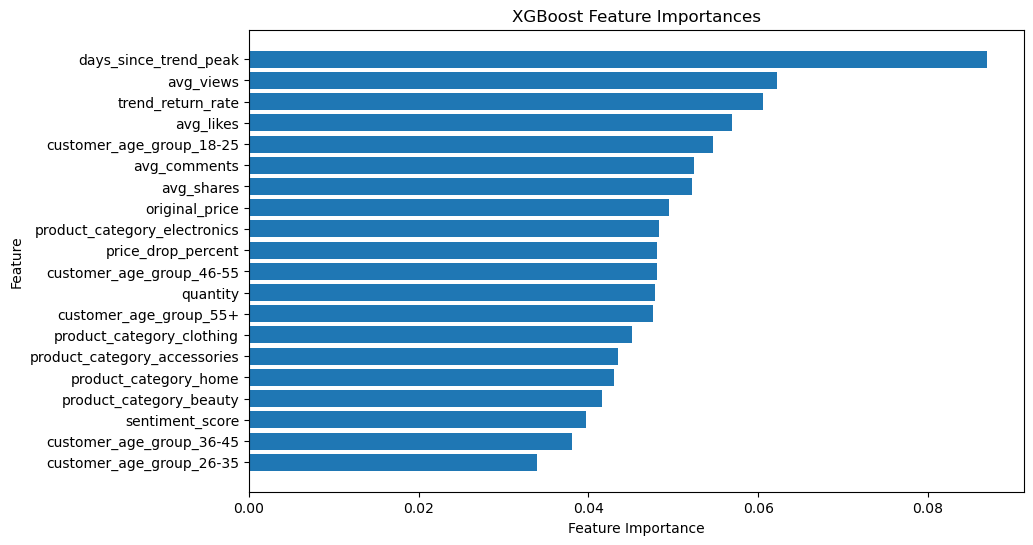


=== Feature Importance Ranking ===
                         Feature  Importance
4          days_since_trend_peak    0.086943
5                      avg_views    0.062149
9              trend_return_rate    0.060511
6                      avg_likes    0.056886
15      customer_age_group_18-25    0.054666
7                   avg_comments    0.052417
8                     avg_shares    0.052199
0                 original_price    0.049507
13  product_category_electronics    0.048309
3             price_drop_percent    0.048122
18      customer_age_group_46-55    0.048096
1                       quantity    0.047781
19        customer_age_group_55+    0.047562
12     product_category_clothing    0.045068
10  product_category_accessories    0.043503
14         product_category_home    0.043053
11       product_category_beauty    0.041556
2                sentiment_score    0.039688
17      customer_age_group_36-45    0.038048
16      customer_age_group_26-35    0.033937

Interpretation Not

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

importances = model.feature_importances_
feat_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=True)  # sort for nice plot

plt.figure(figsize=(10, 6))
plt.barh(feat_df["Feature"], feat_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importances")
plt.show()

print("\n=== Feature Importance Ranking ===")
print(feat_df.sort_values(by="Importance", ascending=False))

print("\nInterpretation Notes:")
print("""
- Higher bars mean the feature had more influence in decision-making.
- Low-importance features might be removable for a simpler model.
- Combine with evaluation metrics to see if important features align with domain expectations.
""")
